In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from py_help import torch_helper as tc_help
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import nltk 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
from tqdm.notebook import tqdm 
import os
from more_itertools import take
from torch_models.mdl1 import Model1
from torch_models.tc_baseline import tc_baseline

import transformers
from transformers import DistilBertTokenizer, RobertaTokenizer, DistilBertTokenizerFast, DistilBertConfig, TFDistilBertModel, BertModel, BertTokenizerFast, DistilBertModel
from transformers import BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

2022-09-25 08:58:34.139341: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-25 08:58:34.261525: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-25 08:58:34.757439: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-09-25 08:58:34.757503: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

# Device setup

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

batch_size = 64

max_length = 128

cuda


In [3]:

files = ['../Dataset/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/' + file for file in os.listdir('../Dataset/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/')]
files

['../Dataset/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '../Dataset/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '../Dataset/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

# Preparing the dataset for label encoding

In [4]:
train_data = tc_help().get_lines(files[1])
train_data[:5]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n']

In [5]:
train_contents = tc_help().pre_processor(files[1])
test_contents = tc_help().pre_processor(files[0])
val_contents = tc_help().pre_processor(files[2])

train_df = pd.DataFrame(train_contents)
test_df = pd.DataFrame(test_contents)
val_df = pd.DataFrame(val_contents)

In [6]:
len(train_contents), len(test_contents), len(val_contents)

(180040, 30135, 30212)

In [7]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64


<AxesSubplot: >

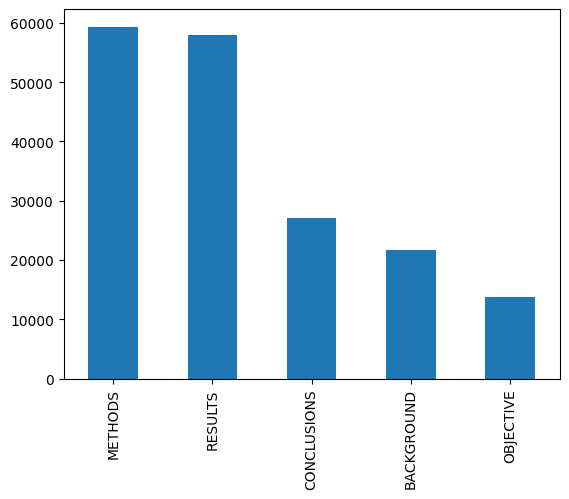

In [8]:
# grab the val counts for the targets
# train_df['target'].value_counts()
# plt.figure(figsize=(10,7))
# sns.countplot('target', data=train_df)
print(train_df.target.value_counts())
train_df.target.value_counts().plot.bar()

In [9]:
# TODO STOP WORD REMOVAL

nltk.download("stopwords")
swrds = stopwords.words("english")
print(swrds[:15])
porter = PorterStemmer()


def nltk_preprocessor(sentence,stopwords=swrds):
        """preprocessing the data based on nltk STOPWORDS

        Args:
            sentence (string): The string or the sentence that is to be passed 

        Returns:
            sentence (string): The pre proceesed result from the function 
        """

        sentence = sentence.lower()
        # get rid of the stop words
        pt = re.compile(r"\b(" + r"|".join(stopwords) + r")\b\s*")
        sentence = pt.sub("", sentence)
        # paranthesis cases 
        sentence = re.sub(r"\([^)]*\)", "", sentence)
        # handling the spaces and the filters
        sentence = re.sub(r"([-;;.,!?<=>])", r" \1", sentence)
        sentence = re.sub(r"[^A-Za-z0-9]", " ", sentence) # removing all cases for non alpha numeric characters 
        sentence = re.sub(" +", " ", sentence)
        sentence = sentence.strip()

        return sentence 

prep_df = train_df.copy()
prep_df.text = prep_df.text.apply(nltk_preprocessor)
print(f"{train_df.text.values[0]}\n\n{prep_df.text.values[0]}")
print("The number of sentences for training are : {} \nThe number of sentences for vaildation are : {}\n The number of sentences for testing are : {}".format(len(train_df['text'].tolist()),len(val_df['text'].tolist()),len(test_df['text'].tolist())))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/markins/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours']
to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .

investigate efficacy weeks daily low dose oral prednisolone improving pain mobility systemic low grade inflammation short term whether effect would sustained weeks older adults moderate severe knee osteoarthritis
The number of sentences for training are : 180040 
The number of sentences for vaildation are : 30212
 The number of sentences for testing are : 30135


In [10]:
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [11]:
train_sz,val_sz,test_sz = 0.7,0.2,0.1
x,y = prep_df['text'].values,prep_df['target'].values
x_train,x_val,x_test,y_train,y_val,y_test = tc_help().data_splitter(x,y,train_sz)
print('Trained Data shape ----> X_train : {} , Y_train : {} \nValidation Data Shape -----> X_val : {} , Y_val : {}\nTesting Data Shape -----> X_test : {} , Y_test : {}'.format(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape))

Trained Data shape ----> X_train : (126027,) , Y_train : (126027,) 
Validation Data Shape -----> X_val : (27006,) , Y_val : (27006,)
Testing Data Shape -----> X_test : (27007,) , Y_test : (27007,)


In [12]:
lb = tc_help().lb_encoder
lb.lb_fit(y_train)
classes = len(lb)
print('The nos label encoded classes : {}'.format(classes))
lb.target_classes

The nos label encoded classes : 5


{'BACKGROUND': 0, 'CONCLUSIONS': 1, 'METHODS': 2, 'OBJECTIVE': 3, 'RESULTS': 4}

In [13]:
lb.target_classes.keys()

dict_keys(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'])

In [14]:
# labelling targets to nos 
y_train,y_val,y_test = lb.lb_encoder(y_train),lb.lb_encoder(y_val),lb.lb_encoder(y_test)


In [15]:
cnts = np.bincount(y_train)
clw = {index : 1.0/cnts for index , cnts in enumerate(cnts)}
print("Counts and weights of the classes respectively : {} and \n {} ".format(cnts,clw))

Counts and weights of the classes respectively : [15209 19017 41547  9687 40567] and 
 {0: 6.575054244197515e-05, 1: 5.258452963138245e-05, 2: 2.4069126531398175e-05, 3: 0.00010323113451016826, 4: 2.4650578056055415e-05} 


# Tokenizing

In [16]:
tknz = tc_help().ct_tokenzr
tknz.__init__(ch_lvl=False, nos_tkns=60000)
tknz.txt_fitter(txt=x_train)
VOCABULARY_SZ = len(tknz)
print(VOCABULARY_SZ)

38839


In [17]:
# grab some sample tokens
print(take(5, tknz.tkn_to_idx.items()))
print(f"The tokens with the leats significance and freq : {tknz.min_tkn_frq}")

[('<PAD>', 0), ('<UNK>', 1), ('patients', 2), ('group', 3), ('treatment', 4)]
The tokens with the leats significance and freq : 1


In [18]:
# texts to nums
x_train =  tknz.txt_seq(x_train)
x_val = tknz.txt_seq(x_val)
x_test = tknz.txt_seq(x_test)

In [19]:
class CustomDataset(Dataset):
    """Generates custom tokenized preprocessed dataset
    """


    def __init__(self, x, y):
        self.x = x 
        self.y = y 

    def collation(self, data):
        """Preprocessing on a batch of dataset

        Args:
            data (ndarray): A batch of dataset in an array format
        """
        # grabbing the input
        data = np.array(data)
        x = data[:,0]
        len_seq, y = data[:,1], data[:,2]
        # inputs getting padded
        x = tc_help().seq_padder(seq=x)
        # inputs -----> tensors
        x = torch.LongTensor(x.astype(np.int32))
        len_seq = torch.LongTensor(len_seq.astype(np.int32))
        y = torch.LongTensor(y.astype(np.int32))
        return x, len_seq, y

    def create_datald(self, batch_size, shuffle=False,drop_last=False):
        dloader = DataLoader(dataset=self, batch_size=batch_size, collate_fn=self.collation, shuffle=shuffle, drop_last=drop_last, pin_memory=True)
        return dloader

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, pos):
        return [self.x[pos], len(x), self.y[pos]]
    
    def __str__(self):
        return f"<CustomDataset (N= {len(self)})>"

train_data = CustomDataset(x_train,y_train)
test_data = CustomDataset(x_val, y_val)
val_data = CustomDataset(x_test, y_test)
train_dl = train_data.create_datald(batch_size=64)
test_dl = test_data.create_datald(batch_size=64)
val_dl = test_data.create_datald(batch_size=64)

len(train_dl), len(val_dl), len(test_dl)

(1970, 422, 422)

In [20]:
train_data[12]

[array([ 4277,  3393,  6657,  7097,  4018,   929, 27313]), 180040, 0]

In [21]:
batchset_x , batch_sq_ln, batchset_y = next(iter(train_dl))
batchset_x[0]


/tmp/ipykernel_17589/517947845.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)


tensor([ 3243,  3127, 22284,   901,  1579,  2005,   357,    80,   711,   607,
          753,   244,   222,  5100,    65,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])

In [22]:
# Training on model 1
model = Model1(
    embed_dm = 128,
    hd_dim = 128,
    voc_size=VOCABULARY_SZ,
    num_lyrs = 2,
    ln_output = 64,
    num_classes = classes
)

In [23]:
model = model.to(device)
model

Model1(
  (embed): Embedding(38839, 128)
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True, bidirectional=True)
  (fcd1): Linear(in_features=256, out_features=64, bias=True)
  (fcd2): Linear(in_features=64, out_features=5, bias=True)
  (drop_fn): Dropout(p=0.3, inplace=False)
)

In [24]:
# Training the model
lr_rate, patience, epochs  = 1e-4, 5, 25
# losses
cl_wts = torch.Tensor(list(clw.values())).to(device)
loss_func = nn.CrossEntropyLoss(weight=cl_wts)
optimizer = optim.Adam(model.parameters(), lr=lr_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor = 0.1, patience=3)
trainer_arch = tc_baseline(
    model=model,
    device=device,
    loss_func=loss_func,
    optimizer=optimizer,
    scheduler=scheduler,
    dump_path='model_dumps/model1.pt'
)

In [25]:
appt_model = trainer_arch.training_engine(
    epochs,
    patience,
    train_dl,
    val_dl,
)

<----------------------Training in EPOCH: 1 ------------------------>


  0%|          | 0/1970 [00:00<?, ?it/s]

/tmp/ipykernel_17589/517947845.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)


IndexError: index 180039 is out of bounds for dimension 1 with size 30